In [1]:
# Dependencies
import pandas as pd 
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torch.optim as optim 
import torch 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Data Preparation
df = pd.read_csv("./AMZN.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


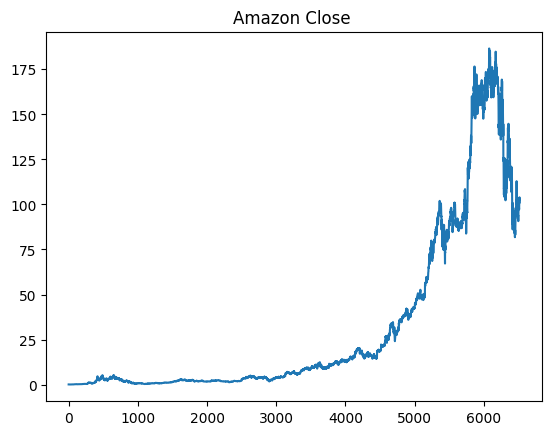

In [15]:
# Data Exploration
plt.plot(df["Close"].values)
plt.title("Amazon Close ")
plt.show()

In [4]:
# Define sliding window
def sliding_window(data , seq_length):
    x , y = [] , []
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x) , np.array(y) 

In [5]:
# Define MinMaxScaler
scaler = MinMaxScaler()
training_data = scaler.fit_transform(df["Close"].values.reshape(-1,1))

In [6]:
seq_length = 7 
x , y = sliding_window(training_data , seq_length)
print(x.shape , y.shape)

(6508, 7, 1) (6508, 1)


In [7]:
# Split data into train and test
train_size = int(len(y)*0.9)
test_size = len(y) - train_size

In [8]:
# Convert data into torch tensor
x_data = torch.tensor(x , dtype = torch.float32)
y_data = torch.tensor(y , dtype = torch.float32)

In [9]:
# Define train and test
x_train = x_data[:train_size]
y_train = y_data[:train_size]

In [10]:
# Define train and test
x_test = x_data[train_size:]
y_test = y_data[train_size:]

In [11]:
# Define LSTM Model
class LSTM(nn.Module):
    def __init__(self , num_classes ,input_size , hidden_size , num_layers ):
        super(LSTM , self).__init__()
        self.num_classes = num_classes 
        self.num_layers = num_layers
        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size = input_size , hidden_size = hidden_size , num_layers = num_layers , batch_first = True)

        self.fc = nn.Linear(hidden_size , num_classes)
    def forward(self , x):
        h_0 = torch.zeros(self.num_classes, x.size(0) , self.hidden_size)
        c_0 = torch.zeros(self.num_classes , x.size(0) , self.hidden_size)
        lstm_out , (h_out , _) = self.lstm(x , (h_0 , c_0))
        h_out = h_out.view(-1 , self.hidden_size)
        out = self.fc(h_out)
        return out 
    
model = LSTM(input_size=1 , hidden_size=2 , num_layers=1 , num_classes=1)

In [12]:
# Define Hyperparameters
epochs = 2000
lr = 0.01 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters() , lr = lr)

In [13]:
# Train the Model 
for epoch in range(epochs):
    output = model(x_train)
    optimizer.zero_grad()
    loss = criterion(output , y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.02922
Epoch: 100, loss: 0.00057
Epoch: 200, loss: 0.00022
Epoch: 300, loss: 0.00010
Epoch: 400, loss: 0.00006
Epoch: 500, loss: 0.00004
Epoch: 600, loss: 0.00003
Epoch: 700, loss: 0.00003
Epoch: 800, loss: 0.00003
Epoch: 900, loss: 0.00003
Epoch: 1000, loss: 0.00002
Epoch: 1100, loss: 0.00002
Epoch: 1200, loss: 0.00002
Epoch: 1300, loss: 0.00002
Epoch: 1400, loss: 0.00002
Epoch: 1500, loss: 0.00002
Epoch: 1600, loss: 0.00002
Epoch: 1700, loss: 0.00002
Epoch: 1800, loss: 0.00002
Epoch: 1900, loss: 0.00002


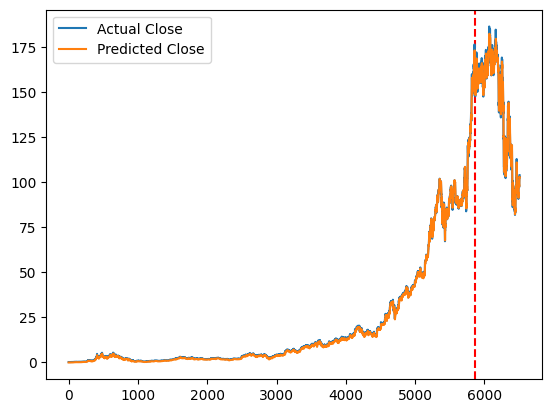

In [16]:
# Eval the Model 
model.eval()
train_predict = model(x_data)

data_predict = train_predict.data.numpy()
data_plot = y_data.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
data_plot = scaler.inverse_transform(data_plot)

plt.axvline(x = train_size , c = "r" , linestyle = "--")
plt.plot(data_plot , label = "Actual Close")
plt.plot(data_predict , label = "Predicted Close")
plt.legend()
plt.show()